In [75]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

# 要上传 multiprocessing_env.py 文件

In [76]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [77]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [78]:
from multiprocessing_env import SubprocVecEnv
# stack 多个独立的环境到 单个环境 --> 训练的每个step不再是在1个env上训练agent，而是堆叠的n个环境上训练
# 用vectorized环境，在每个episode后面会自动reset，因此下一个episode开始的observation是上一个episode done时候返回的，而不是结束时候的
# https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html#subprocvecenv

num_envs = 16
env_name = "CartPole-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)    # 每个环境都是一样的名字初始化
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]    # 多个环境的创建程序的list
# stable_baselines.common.vec_env.SubprocVecEnv(env_fns, start_method=None) input is env functions without execution
envs = SubprocVecEnv(envs)  # create multiprocess vectorized wrapper for multiple env, distributed each env into its own process
# https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html#subprocvecenv  stable_baselines.common.vec_env.SubprocVecEnv
# envs <multiprocessing_env.SubprocVecEnv at 0x7f1fbfe2a650>

env = gym.make(env_name)        # single used for test_env

In [79]:
envs

In [80]:
env

<TimeLimit<CartPoleEnv<CartPole-v0>>>

<h2>Neural Network</h2>

In [81]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):  # ? std  https://spinningup.openai.com/en/latest/algorithms/sac.html
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(dim=1),      # 在dimension1，即axis1，每个agent的2个动作上做softmax
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)   # torch.Size([16, 2]),16个agent分别在0，1动作上的概率，如 [0.5090, 0.4910]
        dist  = Categorical(probs)      # 根据概率抽样的采样器  https://www.jianshu.com/p/c73948239c42
        return dist, value

In [82]:
def plot(frame_idx, rewards):
    clear_output(True)      # plot会每次清空，然后只画出当前测试的rewards曲线
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):        # 测试环境 --> 用当前的model指导1个新的agent在全新的测试环境从头走到结束，打印出总的rewards
    '''
    vis: boolean, show visualization or not
    '''
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:     # 只要没结束就从头一直走到结束，打印 R
        state = torch.FloatTensor(state).unsqueeze(0).to(device)    # 这里只传入1个state，但unsqueeze到 [1, 4]
        dist, _ = model(state)      # 只是为了获得行动
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

<h1>A2C: Synchronous Advantage Actor Critic</h1>
<h3><a href="https://blog.openai.com/baselines-acktr-a2c/#a2canda3c">OpenAI Blog:</a></h3>
<p>The Asynchronous Advantage Actor Critic method (A3C) has been very influential since the paper was published. The algorithm combines a few key ideas:</p>

<ul>
    <li>An updating scheme that operates on fixed-length segments of experience (say, 20 timesteps) and uses these segments to compute estimators of the returns and advantage function.</li>
    <li>Architectures that share layers between the policy and value function.</li>
    <li>Asynchronous updates.</li>
</ul>

<p>After reading the paper, AI researchers wondered whether the asynchrony led to improved performance (e.g. “perhaps the added noise would provide some regularization or exploration?“), or if it was just an implementation detail that allowed for faster training with a CPU-based implementation.</p>

<p>As an alternative to the asynchronous implementation, researchers found you can write a synchronous, deterministic implementation that waits for each actor to finish its segment of experience before performing an update, averaging over all of the actors. One advantage of this method is that it can more effectively use of GPUs, which perform best with large batch sizes. This algorithm is naturally called A2C, short for advantage actor critic. (This term has been used in several papers.)</p>

In [83]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    '''
    作为true labels
    use bellman equation(TD) to estimate the real R for each step
    gamma: discount factor
    '''
    R = next_value  # 最后一个时刻的value就是模型估计的value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [84]:
num_inputs  = envs.observation_space.shape[0]   # envs.observation_space.shape (4,) 取出4
# 每个env的state对应4的长度
num_outputs = envs.action_space.n       # 2

#Hyper params:
hidden_size = 256
lr          = 3e-4
num_steps   = 5

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters())

In [86]:
max_frames   = 20000        # max frame是所有episode的总的steps数
frame_idx    = 0
test_rewards = []

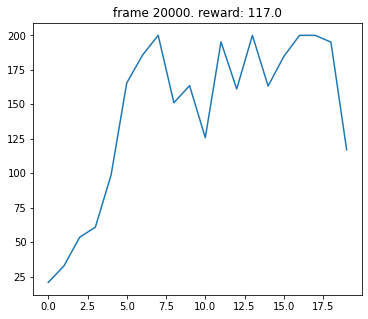

In [89]:
state = envs.reset()    # (16,4) multiple states from envs

while frame_idx < max_frames:

    log_probs = []
    values    = []
    rewards   = []
    masks     = []
    entropy = 0

    # sampling num_steps samples
    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)  # 实际传入的state相当于独立的16个x
        # dist: action distribution from actor
        # value: predicted value from Critic, [16, 1]

        action = dist.sample()  # sample according to distribution from Actor
        # tensor([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])  每个维度对应1个env
        next_state, reward, done, _ = envs.step(action.cpu().numpy())   # one actual move in envs, to get actual reward and next_state
        # next_state (16, 4), reward 16 intermediate reward, done 16 
        log_prob = dist.log_prob(action)    # 16给了action，每个agent只留action的；原本dist.log_prob 是 (16,2) 即传给dist的probs对应取log
        # dist.log_prob() 是 logarithm of the density or probability -> log likelihood  https://stackoverflow.com/a/63308446/15994835
        entropy += dist.entropy().mean()    # dist.entropy() 16

        log_probs.append(log_prob)
        values.append(value)    # 加上 模型用来预测 这一步16个agent各自的value
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))   # 先转float，再 unsqueeze(1)，即在第1维加维，即16 -> [16, 1]
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))   # mask掉完成的，未完成是1，完成在mask中是0
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_rewards.append(np.mean([test_env() for _ in range(10)]))
            plot(frame_idx, test_rewards)   # 每1000步打印一次idx和对应模型获得的rewards曲线
    
    # 还要用模型多计算一次下一步的 expected V, 作为 Vt+1
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)       # 这里只用到了预测的value，没有用action或采取action
    returns = compute_returns(next_value, rewards, masks)   # 只是为了计算cumulative value作为target
    # ？粘合起来是5个steps， 16个envs的每个steps，共80个， 作为1个mini-batch
    log_probs = torch.cat(log_probs)        # 80, 5*[16] -> [80]，带计算图
    returns   = torch.cat(returns).detach() # 80 * [1] -> [80,1]
    values    = torch.cat(values)           # value带计算图

    advantage = returns - values            # advantage 带计算图
    # return: true label, values: predictions,  advantages of corresponding action
    # loss中Actor和Critic 两部分的loss都依赖于 advantage
    actor_loss  = -(log_probs * advantage.detach()).mean()  # ? 为什么只detach一个 negative log likelihood weighted by advantages
    critic_loss = advantage.pow(2).mean()       # pow(2).mean() 是 mean square error带计算图
    # jointly 同时训练2个neural network
    loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy     # ？why entropy， loss也带计算图

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()